# Precip statistics from SEA-POL when it is raining at the ship
- SEA-POL 2D low-level rain rate
- Disdrometer
- Rain gauge

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc, colors, ticker
import matplotlib.dates as mdates
import matplotlib.transforms as transforms
from matplotlib.lines import Line2D
from scipy.interpolate import interp2d, RectBivariateSpline
from datetime import datetime, timedelta
import pandas as pd
import cftime
import seaborn as sns
import json
from thermo_functions import *
from orcestra_read_data import *
import glob
import os

In [35]:
# Define color-blind safe colors
cb_orange = [230/255, 159/255, 0]
cb_skyblue = [86/255, 180/255, 233/255]
cb_green = [0, 158/255, 115/255]
cb_yellow = [240/255, 228/255, 66/255]
cb_blue = [0, 114/255, 178/255]
cb_red = [213/255, 94/255, 0]
cb_purple = [204/255, 121/255, 167/255]


In [3]:
# helper function for skinny box plots
def _q_stats(data):
    vals = np.array([v for v in data if not np.isnan(v)])
    if vals.size == 0:
        return np.nan, np.nan, np.nan, np.nan
    q1, q2, q3 = np.nanpercentile(vals, [25, 50, 75])
    mean = np.nanmean(vals)
    return q1, q2, q3, mean

In [90]:
#Set start and end times
start_time = np.datetime64('2024-08-16T08:00:00')
end_time = np.datetime64('2024-09-23T16:50:00')

#Set E/W boundary
lonEW = -40

### DSHIP data

In [5]:
#Open ship data
#DSHIP = xr.open_dataset('../../data/meteor_meteo_dship_20240923.nc')
#CID: QmSSrT1UdtocfQS5yWSHFEJwJjqcNXjq2F1QfvNgLuEqSN
DSHIP= xr.open_dataset('ipns://latest.orcestra-campaign.org/products/METEOR/DShip.zarr',engine='zarr')
DSHIP

<xarray.Dataset> Size: 20MB
Dimensions:           (time: 58980)
Coordinates:
    lat               (time) float64 472kB ...
    lon               (time) float64 472kB ...
  * time              (time) datetime64[ns] 472kB 2024-08-14 ... 2024-09-23T2...
Data variables: (12/39)
    PM1               (time) float64 472kB ...
    PM10              (time) float64 472kB ...
    PM2p5             (time) float64 472kB ...
    lwr               (time) float64 472kB ...
    p_air             (time) float64 472kB ...
    rh_board          (time) float64 472kB ...
    ...                ...
    wdir              (time) float64 472kB ...
    wdir_rel          (time) float64 472kB ...
    wspd              (time) float64 472kB ...
    wspd_kn           (time) float64 472kB ...
    wspd_rel          (time) float64 472kB ...
    wspd_rel_kn       (time) float64 472kB ...
Attributes:
    creator_email:  hans.segura@mpimet.mpg.de
    creator_name:   Hans Segura
    featureType:    trajectory
    history:        Converted to Zarr by Lukas Kluft (lukas.kluft@mpimet.mpg.de)
    license:        CC-BY-4.0
    platform:       RV METEOR
    project:        ORCESTRA, BOW-TIE
    source:         DVS DShip
    title:          Ship information database (DVS DShip) of METEOR cruise M203

In [92]:
#Find time when ship crosses 40W
iEW = np.where(DSHIP.lon <= lonEW)[0]
iEW = int(iEW[0])
timeEW = DSHIP.time[iEW]

In [6]:
#Find indices for start and end times
index_start = np.where(pd.to_datetime(DSHIP.time) == start_time)[0]
index_start = int(index_start[0])

index_end = np.where(pd.to_datetime(DSHIP.time) == end_time)[0]
index_end = int(index_end[0])

In [7]:
#Interpolate DSHIP data to 10-min resolution

ship_time_interp = pd.date_range(start_time, end_time, freq='10min')
ship_lat_interp = np.interp(ship_time_interp,DSHIP.time,DSHIP.lat)
ship_lon_interp = np.interp(ship_time_interp,DSHIP.time,DSHIP.lon)

### Precipitation - disdrometer

In [8]:
#disdro = xr.open_dataset('/huracan/tank4/cornell/ORCESTRA/M203/Distrometer/QC/final/DSD_METEOR_merged.nc')
#CID: QmajLZ8KboBuGsVzUsKcnDVRbsZp3ybzepYPjLKcfhabcE
disdro = xr.open_dataset('ipns://latest.orcestra-campaign.org/products/METEOR/disdrometer/DSD_METEOR_merged.zarr',engine='zarr')
disdro

<xarray.Dataset> Size: 255MB
Dimensions:                       (time: 56160, particle_size: 32,
                                   raw_fall_velocity: 32)
Coordinates:
  * particle_size                 (particle_size) float32 128B 0.062 ... 24.5
  * raw_fall_velocity             (raw_fall_velocity) float32 128B 0.05 ... 20.8
  * time                          (time) datetime64[ns] 449kB 2024-08-16 ... ...
Data variables: (12/45)
    Nd                            (time, particle_size) float32 7MB ...
    adr_c                         (time) float32 225kB ...
    adr_s                         (time) float32 225kB ...
    adr_x                         (time) float32 225kB ...
    ai_c                          (time) float32 225kB ...
    ai_s                          (time) float32 225kB ...
    ...                            ...
    zdr_c                         (time) float32 225kB ...
    zdr_s                         (time) float32 225kB ...
    zdr_x                         (time) float32 225kB ...
    zh_c                          (time) float32 225kB ...
    zh_s                          (time) float32 225kB ...
    zh_x                          (time) float32 225kB ...
Attributes: (12/24)
    creator_email:                   delianb@colostate.edu
    creator_name:                    Delián Colón-Burgos
    featureType:                     trajectory
    history:                         converted to Zarr by Lukas Kluft (lukas....
    keywords:                        disdrometer, rainrate, parsivel, meteor,...
    license:                         CC-BY-4.0
    ...                              ...
    summary:                         The merged version contains data from th...
    title:                           Merged PARSIVEL Disdrometer QCed data
    tmatrix_canting_mean_angle:      0.0 degrees
    tmatrix_canting_std:             7.5 degrees
    tmatrix_drop_model:              Thurai and Bringi (2005)
    tmatrix_scattering_temperature:  20 C

In [9]:
# Calculate time frequency of precip (fraction of times within a 10-minute interval with precip)
precip_freq_disdro = np.zeros_like(ship_time_interp, dtype=float)
for i, t in enumerate(ship_time_interp):
    # Find the indices of disdro data within the 10-minute interval
    mask = (disdro.time >= t) & (disdro.time < t + np.timedelta64(10, 'm'))
    # Calculate the frequency of precip within that 10-minute interval
    disdro_precip_mask = disdro.rain_rate_qc[mask]
    precip_freq_disdro[i] = np.sum(disdro_precip_mask > 0) / np.sum(mask)


In [106]:
# Split into East and West
precip_freq_disdroE = precip_freq_disdro[ship_time_interp < np.datetime64(timeEW.values)]
precip_freq_disdroW = precip_freq_disdro[ship_time_interp >= np.datetime64(timeEW.values)]

### Precipitation - rain gauge

In [10]:
#CID: QmYQpz2ew8GYa58aED5h2ViYLWtq99bYWvxVNw7KuNaASs
gauge = xr.open_dataset('ipns://latest.orcestra-campaign.org/products/METEOR/rain_gauge/M203_Niederschlag_Stand_240923-2227.zarr',engine='zarr')
gauge

<xarray.Dataset> Size: 5MB
Dimensions:  (time: 55628)
Coordinates:
    height   float64 8B ...
  * time     (time) datetime64[ns] 445kB 2024-08-16T07:19:00 ... 2024-09-23T2...
Data variables:
    DD       (time) int64 445kB ...
    Dauer    (time) int64 445kB ...
    FF       (time) float64 445kB ...
    Lat      (time) float64 445kB ...
    Long     (time) float64 445kB ...
    RH       (time) float64 445kB ...
    RR_SRM   (time) float64 445kB ...
    TT       (time) float64 445kB ...
    Tro1     (time) int64 445kB ...
    Trs      (time) int64 445kB ...
    VVV      (time) int64 445kB ...
Attributes:
    creator_email:  Martin.Stelzner@dwd.de, daniel.klocke@mpimet.mpg.de
    creator_name:   Martin Stelzner, Daniel Klocke
    featureType:    trajectory
    history:        Converted to Zarr by Lukas Kluft (lukas.kluft@mpimet.mpg.de)
    keywords:       precipitation amount, precipitation gauge, precipitation ...
    license:        CC-BY-4.0
    platform:       RV METEOR
    project:        ORCESTRA, BOW-TIE
    summary:        The rain gauge has an upper and a lateral collecting surf...
    title:          Rain gauge measurements during METEOR cruise M203

In [11]:
# Calculate time frequency of precip (fraction of times within a 10-minute interval with precip)
precip_freq_gauge = np.zeros_like(ship_time_interp, dtype=float)
for i, t in enumerate(ship_time_interp):
    # Find the indices of gauge data within the 10-minute interval
    mask = (gauge.time >= t) & (gauge.time < t + np.timedelta64(10, 'm'))
    # Calculate the frequency of precip within that 10-minute interval
    gauge_precip_mask = gauge.RR_SRM[mask]
    precip_freq_gauge[i] = np.sum(gauge_precip_mask > 0) / np.sum(mask)


In [108]:
# Split into East and West
precip_freq_gaugeE = precip_freq_gauge[ship_time_interp < np.datetime64(timeEW.values)]
precip_freq_gaugeW = precip_freq_gauge[ship_time_interp >= np.datetime64(timeEW.values)]

### Precipitation - SEA-POL

In [12]:
seapol = xr.open_dataset('../../data/SEA-POL_4v1.1_rainrate_2D_spatial_means_reg10.nc')
seapol

<xarray.Dataset> Size: 486kB
Dimensions:       (time: 5526)
Coordinates:
  * time          (time) datetime64[ns] 44kB 2024-08-16T08:00:00 ... 2024-09-...
Data variables: (12/15)
    rain245_mean  (time) float32 22kB ...
    rain120_mean  (time) float32 22kB ...
    rain60_mean   (time) float32 22kB ...
    rain12_mean   (time) float32 22kB ...
    rain1_mean    (time) float32 22kB ...
    rain245_int   (time) float32 22kB ...
    ...            ...
    rain1_int     (time) float32 22kB ...
    rain245_frac  (time) float64 44kB ...
    rain120_frac  (time) float64 44kB ...
    rain60_frac   (time) float64 44kB ...
    rain12_frac   (time) float64 44kB ...
    rain1_frac    (time) float64 44kB ...
Attributes:
    title:        Spatial mean rainrate from SEA-POL long-range, low-elevatio...
    description:  Spatial means of rainrate from SEA-POL long-range, low-elev...
    source:       SEA-POL Level4v1.1 Gridded 2D Rain Rate
    units:        mm/h

In [113]:
# Split into East and West
seapolE = seapol.sel(time=slice(None, np.datetime64(timeEW.values)))
seapolW = seapol.sel(time=slice(np.datetime64(timeEW.values), None))

Extract SEA-POL fractional area coverage of precipitation when precip frequency at ship within that 10-minute period is zero/non-zero (then try other thresholds)

In [13]:
#threshold of precip frequency at ship within that 10-minute period
pfreq_threshold = 0

fa245_gauge_zero = seapol.rain245_frac.where(precip_freq_gauge <= pfreq_threshold)
fa245_gauge_nonzero = seapol.rain245_frac.where(precip_freq_gauge > pfreq_threshold)

fa120_gauge_zero = seapol.rain120_frac.where(precip_freq_gauge <= pfreq_threshold)
fa120_gauge_nonzero = seapol.rain120_frac.where(precip_freq_gauge > pfreq_threshold)

fa60_gauge_zero = seapol.rain60_frac.where(precip_freq_gauge <= pfreq_threshold)
fa60_gauge_nonzero = seapol.rain60_frac.where(precip_freq_gauge > pfreq_threshold)

fa12_gauge_zero = seapol.rain12_frac.where(precip_freq_gauge <= pfreq_threshold)
fa12_gauge_nonzero = seapol.rain12_frac.where(precip_freq_gauge > pfreq_threshold)

fa245_disdro_zero = seapol.rain245_frac.where(precip_freq_disdro <= pfreq_threshold)
fa245_disdro_nonzero = seapol.rain245_frac.where(precip_freq_disdro > pfreq_threshold)

fa120_disdro_zero = seapol.rain120_frac.where(precip_freq_disdro <= pfreq_threshold)
fa120_disdro_nonzero = seapol.rain120_frac.where(precip_freq_disdro > pfreq_threshold)

fa60_disdro_zero = seapol.rain60_frac.where(precip_freq_disdro <= pfreq_threshold)
fa60_disdro_nonzero = seapol.rain60_frac.where(precip_freq_disdro > pfreq_threshold)

fa12_disdro_zero = seapol.rain12_frac.where(precip_freq_disdro <= pfreq_threshold)
fa12_disdro_nonzero = seapol.rain12_frac.where(precip_freq_disdro > pfreq_threshold)


In [114]:
#threshold of precip frequency at ship within that 10-minute period -- EAST
pfreq_threshold = 0

fa245_gauge_zeroE = seapolE.rain245_frac.where(precip_freq_gaugeE <= pfreq_threshold)
fa245_gauge_nonzeroE = seapolE.rain245_frac.where(precip_freq_gaugeE > pfreq_threshold)

fa120_gauge_zeroE = seapolE.rain120_frac.where(precip_freq_gaugeE <= pfreq_threshold)
fa120_gauge_nonzeroE = seapolE.rain120_frac.where(precip_freq_gaugeE > pfreq_threshold)

fa60_gauge_zeroE = seapolE.rain60_frac.where(precip_freq_gaugeE <= pfreq_threshold)
fa60_gauge_nonzeroE = seapolE.rain60_frac.where(precip_freq_gaugeE > pfreq_threshold)

fa12_gauge_zeroE = seapolE.rain12_frac.where(precip_freq_gaugeE <= pfreq_threshold)
fa12_gauge_nonzeroE = seapolE.rain12_frac.where(precip_freq_gaugeE > pfreq_threshold)

fa245_disdro_zeroE = seapolE.rain245_frac.where(precip_freq_disdroE <= pfreq_threshold)
fa245_disdro_nonzeroE = seapolE.rain245_frac.where(precip_freq_disdroE > pfreq_threshold)

fa120_disdro_zeroE = seapolE.rain120_frac.where(precip_freq_disdroE <= pfreq_threshold)
fa120_disdro_nonzeroE = seapolE.rain120_frac.where(precip_freq_disdroE > pfreq_threshold)

fa60_disdro_zeroE = seapolE.rain60_frac.where(precip_freq_disdroE <= pfreq_threshold)
fa60_disdro_nonzeroE = seapolE.rain60_frac.where(precip_freq_disdroE > pfreq_threshold)

fa12_disdro_zeroE = seapolE.rain12_frac.where(precip_freq_disdroE <= pfreq_threshold)
fa12_disdro_nonzeroE = seapolE.rain12_frac.where(precip_freq_disdroE > pfreq_threshold)


In [115]:
#threshold of precip frequency at ship within that 10-minute period -- WEST
pfreq_threshold = 0

fa245_gauge_zeroW = seapolW.rain245_frac.where(precip_freq_gaugeW <= pfreq_threshold)
fa245_gauge_nonzeroW = seapolW.rain245_frac.where(precip_freq_gaugeW > pfreq_threshold)

fa120_gauge_zeroW = seapolW.rain120_frac.where(precip_freq_gaugeW <= pfreq_threshold)
fa120_gauge_nonzeroW = seapolW.rain120_frac.where(precip_freq_gaugeW > pfreq_threshold)

fa60_gauge_zeroW = seapolW.rain60_frac.where(precip_freq_gaugeW <= pfreq_threshold)
fa60_gauge_nonzeroW = seapolW.rain60_frac.where(precip_freq_gaugeW > pfreq_threshold)

fa12_gauge_zeroW = seapolW.rain12_frac.where(precip_freq_gaugeW <= pfreq_threshold)
fa12_gauge_nonzeroW = seapolW.rain12_frac.where(precip_freq_gaugeW > pfreq_threshold)

fa245_disdro_zeroW = seapolW.rain245_frac.where(precip_freq_disdroW <= pfreq_threshold)
fa245_disdro_nonzeroW = seapolW.rain245_frac.where(precip_freq_disdroW > pfreq_threshold)

fa120_disdro_zeroW = seapolW.rain120_frac.where(precip_freq_disdroW <= pfreq_threshold)
fa120_disdro_nonzeroW = seapolW.rain120_frac.where(precip_freq_disdroW > pfreq_threshold)

fa60_disdro_zeroW = seapolW.rain60_frac.where(precip_freq_disdroW <= pfreq_threshold)
fa60_disdro_nonzeroW = seapolW.rain60_frac.where(precip_freq_disdroW > pfreq_threshold)

fa12_disdro_zeroW = seapolW.rain12_frac.where(precip_freq_disdroW <= pfreq_threshold)
fa12_disdro_nonzeroW = seapolW.rain12_frac.where(precip_freq_disdroW > pfreq_threshold)


Plot

FA245 gauge zero, smallest bin: 0.80
FA245 disdro zero, smallest bin: 0.80
FA120 gauge zero, smallest bin: 0.69
FA120 disdro zero, smallest bin: 0.69
FA60 gauge zero, smallest bin: 0.67
FA60 disdro zero, smallest bin: 0.67
FA12 gauge zero, smallest bin: 0.70
FA12 disdro zero, smallest bin: 0.70
Time Freq disdro, smallest bin: 0.89
Time Freq gauge, smallest bin: 0.88


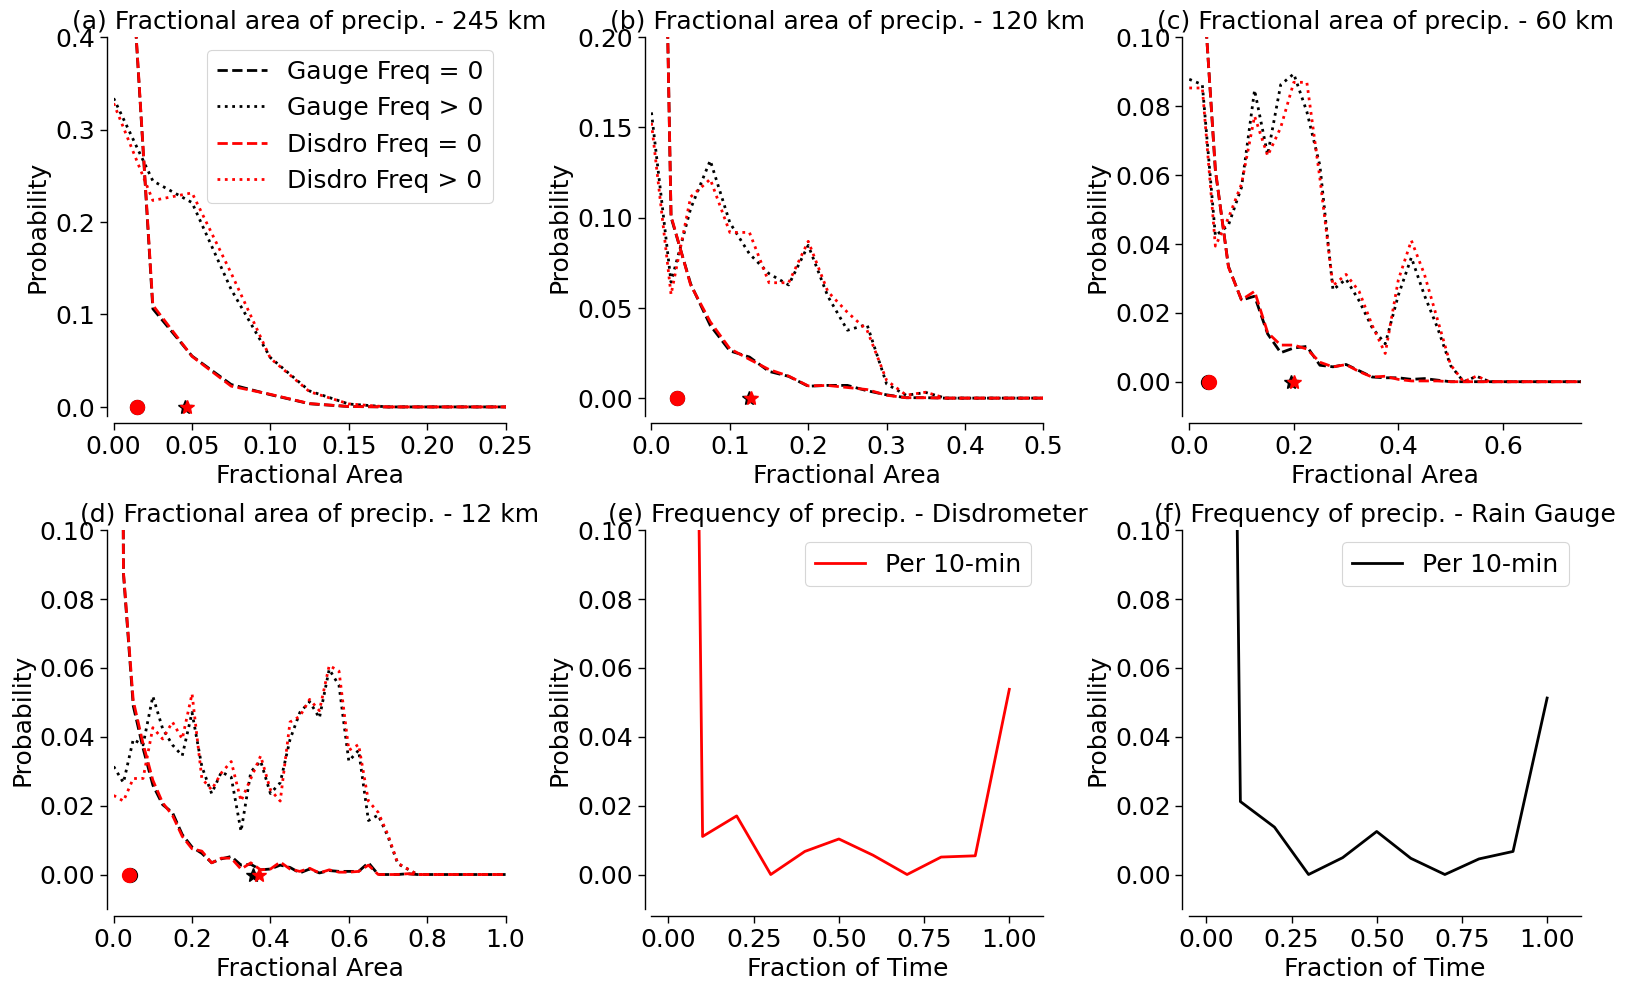

In [84]:
fig, axs = plt.subplots(2,3,figsize=(16,10))

fabins = np.arange(0,1.05,0.025)
ftbins = np.arange(0,1.2,0.1)

## Fractional area 245 km
phist_fa245_gz, bin_edges_gz = np.histogram(fa245_gauge_zero, bins=fabins, density=True)
phist_fa245_gnz, bin_edges_gnz = np.histogram(fa245_gauge_nonzero, bins=fabins, density=True)
phist_fz245_dz, bin_edges_dz = np.histogram(fa245_disdro_zero, bins=fabins, density=True)
phist_fz245_dnz, bin_edges_dnz = np.histogram(fa245_disdro_nonzero, bins=fabins, density=True)

print(f"FA245 gauge zero, smallest bin: {phist_fa245_gz[0]*np.diff(bin_edges_gz)[0]:.2f}")
print(f"FA245 disdro zero, smallest bin: {phist_fz245_dz[0]*np.diff(bin_edges_dz)[0]:.2f}")

axs[0,0].plot(bin_edges_gz[:-1], phist_fa245_gz*np.diff(bin_edges_gz), color='black', linestyle='--', label = 'Gauge Freq = 0', linewidth=2)
axs[0,0].plot(bin_edges_gnz[:-1], phist_fa245_gnz*np.diff(bin_edges_gnz), color='black', linestyle=':', label = 'Gauge Freq > 0', linewidth=2)
axs[0,0].plot(bin_edges_dz[:-1], phist_fz245_dz*np.diff(bin_edges_dz), color='red', linestyle='--', label = 'Disdro Freq = 0', linewidth=2)
axs[0,0].plot(bin_edges_dnz[:-1], phist_fz245_dnz*np.diff(bin_edges_dnz), color='red', linestyle=':', label = 'Disdro Freq > 0', linewidth=2)

axs[0,0].plot(np.nanmean(fa245_gauge_zero.values),0,'o',color='black', markersize=10)
axs[0,0].plot(np.nanmean(fa245_disdro_zero.values),0,'o',color='red', markersize=10)
axs[0,0].plot(np.nanmean(fa245_gauge_nonzero.values),0,'*',color='black', markersize=10)
axs[0,0].plot(np.nanmean(fa245_disdro_nonzero.values),0,'*',color='red', markersize=10)

axs[0,0].set_title('(a) Fractional area of precip. - 245 km',fontsize=18)
axs[0,0].set_xlabel('Fractional Area',fontsize=18)
axs[0,0].set_ylabel('Probability',fontsize=18)
axs[0,0].set_xlim(0,0.25)
axs[0,0].set_ylim(-0.01,0.4)
axs[0,0].legend(fontsize=18)
axs[0,0].tick_params(labelsize=18)

## Fractional area 120 km
phist_fa120_gz, bin_edges_gz = np.histogram(fa120_gauge_zero, bins=fabins, density=True)
phist_fa120_gnz, bin_edges_gnz = np.histogram(fa120_gauge_nonzero, bins=fabins, density=True)
phist_fa120_dz, bin_edges_dz = np.histogram(fa120_disdro_zero, bins=fabins, density=True)
phist_fa120_dnz, bin_edges_dnz = np.histogram(fa120_disdro_nonzero, bins=fabins, density=True)

print(f"FA120 gauge zero, smallest bin: {phist_fa120_gz[0]*np.diff(bin_edges_gz)[0]:.2f}")
print(f"FA120 disdro zero, smallest bin: {phist_fa120_dz[0]*np.diff(bin_edges_dz)[0]:.2f}")

axs[0,1].plot(bin_edges_gz[:-1], phist_fa120_gz*np.diff(bin_edges_gz), color='black', linestyle='--', label = 'East', linewidth=2)
axs[0,1].plot(bin_edges_gnz[:-1], phist_fa120_gnz*np.diff(bin_edges_gnz), color='black', linestyle=':', label = 'West', linewidth=2)
axs[0,1].plot(bin_edges_dz[:-1], phist_fa120_dz*np.diff(bin_edges_dz), color='red', linestyle='--', label = 'East', linewidth=2)
axs[0,1].plot(bin_edges_dnz[:-1], phist_fa120_dnz*np.diff(bin_edges_dnz), color='red', linestyle=':', label = 'West', linewidth=2)

axs[0,1].plot(np.nanmean(fa120_gauge_zero.values),0,'o',color='black', markersize=10)
axs[0,1].plot(np.nanmean(fa120_disdro_zero.values),0,'o',color='red', markersize=10)
axs[0,1].plot(np.nanmean(fa120_gauge_nonzero.values),0,'*',color='black', markersize=10)
axs[0,1].plot(np.nanmean(fa120_disdro_nonzero.values),0,'*',color='red', markersize=10)

axs[0,1].set_title('(b) Fractional area of precip. - 120 km',fontsize=18)
axs[0,1].set_xlabel('Fractional Area',fontsize=18)
axs[0,1].set_ylabel('Probability',fontsize=18)
axs[0,1].set_xlim(0,0.5)
axs[0,1].set_ylim(-0.01,0.2)
#axs[0,1].legend(fontsize=18)
axs[0,1].tick_params(labelsize=18)

## Fractional area 60 km
phist_fa60_gz, bin_edges_gz = np.histogram(fa60_gauge_zero, bins=fabins, density=True)
phist_fa60_gnz, bin_edges_gnz = np.histogram(fa60_gauge_nonzero, bins=fabins, density=True)
phist_fa60_dz, bin_edges_dz = np.histogram(fa60_disdro_zero, bins=fabins, density=True)
phist_fa60_dnz, bin_edges_dnz = np.histogram(fa60_disdro_nonzero, bins=fabins, density=True)

print(f"FA60 gauge zero, smallest bin: {phist_fa60_gz[0]*np.diff(bin_edges_gz)[0]:.2f}")
print(f"FA60 disdro zero, smallest bin: {phist_fa60_dz[0]*np.diff(bin_edges_dz)[0]:.2f}")

axs[0,2].plot(bin_edges_gz[:-1], phist_fa60_gz*np.diff(bin_edges_gz), color='black', linestyle='--', label = 'East', linewidth=2)
axs[0,2].plot(bin_edges_gnz[:-1], phist_fa60_gnz*np.diff(bin_edges_gnz), color='black', linestyle=':', label = 'West', linewidth=2)
axs[0,2].plot(bin_edges_dz[:-1], phist_fa60_dz*np.diff(bin_edges_dz), color='red', linestyle='--', label = 'East', linewidth=2)
axs[0,2].plot(bin_edges_dnz[:-1], phist_fa60_dnz*np.diff(bin_edges_dnz), color='red', linestyle=':', label = 'West', linewidth=2)

axs[0,2].plot(np.nanmean(fa60_gauge_zero.values),0,'o',color='black', markersize=10)
axs[0,2].plot(np.nanmean(fa60_disdro_zero.values),0,'o',color='red', markersize=10)
axs[0,2].plot(np.nanmean(fa60_gauge_nonzero.values),0,'*',color='black', markersize=10)
axs[0,2].plot(np.nanmean(fa60_disdro_nonzero.values),0,'*',color='red', markersize=10)

axs[0,2].set_title('(c) Fractional area of precip. - 60 km',fontsize=18)
axs[0,2].set_xlabel('Fractional Area',fontsize=18)
axs[0,2].set_ylabel('Probability',fontsize=18)
axs[0,2].set_xlim(0,0.75)
axs[0,2].set_ylim(-0.01,0.1)
#axs[0,2].legend(fontsize=18)
axs[0,2].tick_params(labelsize=18)

## Fractional area 12 km
phist_fa12_gz, bin_edges_gz = np.histogram(fa12_gauge_zero, bins=fabins, density=True)
phist_fa12_gnz, bin_edges_gnz = np.histogram(fa12_gauge_nonzero, bins=fabins, density=True)
phist_fa12_dz, bin_edges_dz = np.histogram(fa12_disdro_zero, bins=fabins, density=True)
phist_fa12_dnz, bin_edges_dnz = np.histogram(fa12_disdro_nonzero, bins=fabins, density=True)

print(f"FA12 gauge zero, smallest bin: {phist_fa12_gz[0]*np.diff(bin_edges_gz)[0]:.2f}")
print(f"FA12 disdro zero, smallest bin: {phist_fa12_dz[0]*np.diff(bin_edges_dz)[0]:.2f}")

axs[1,0].plot(bin_edges_gz[:-1], phist_fa12_gz*np.diff(bin_edges_gz), color='black', linestyle='--', label = 'East', linewidth=2)
axs[1,0].plot(bin_edges_gnz[:-1], phist_fa12_gnz*np.diff(bin_edges_gnz), color='black', linestyle=':', label = 'West', linewidth=2)
axs[1,0].plot(bin_edges_dz[:-1], phist_fa12_dz*np.diff(bin_edges_dz), color='red', linestyle='--', label = 'East', linewidth=2)
axs[1,0].plot(bin_edges_dnz[:-1], phist_fa12_dnz*np.diff(bin_edges_dnz), color='red', linestyle=':', label = 'West', linewidth=2)

axs[1,0].plot(np.nanmean(fa12_gauge_zero.values),0,'o',color='black', markersize=10)
axs[1,0].plot(np.nanmean(fa12_disdro_zero.values),0,'o',color='red', markersize=10)
axs[1,0].plot(np.nanmean(fa12_gauge_nonzero.values),0,'*',color='black', markersize=10)
axs[1,0].plot(np.nanmean(fa12_disdro_nonzero.values),0,'*',color='red', markersize=10)

axs[1,0].set_title('(d) Fractional area of precip. - 12 km',fontsize=18)
axs[1,0].set_xlabel('Fractional Area',fontsize=18)
axs[1,0].set_ylabel('Probability',fontsize=18)
axs[1,0].set_xlim(0,1)
axs[1,0].set_ylim(-0.01,0.1)
#axs[1,0].legend(fontsize=18)
axs[1,0].tick_params(labelsize=18)

## Time frequency of precip from disdrometer
phist_fp_disdro, bin_edges = np.histogram(precip_freq_disdro, bins=ftbins, density=True)

print(f"Time Freq disdro, smallest bin: {phist_fp_disdro[0]*np.diff(bin_edges)[0]:.2f}")

axs[1,1].plot(bin_edges[:-1], phist_fp_disdro*np.diff(bin_edges), color='red', label='Per 10-min', linewidth=2)

axs[1,1].set_title('(e) Frequency of precip. - Disdrometer',fontsize=18)
axs[1,1].set_xlabel('Fraction of Time',fontsize=18)
axs[1,1].set_ylabel('Probability',fontsize=18)
axs[1,1].set_xlim(-0.05,1.1)
axs[1,1].set_ylim(-0.01,0.1)
axs[1,1].legend(fontsize=18)
axs[1,1].tick_params(labelsize=18)

## Time frequency of precip from rain gauge
phist_fp_gauge, bin_edges = np.histogram(precip_freq_gauge, bins=ftbins, density=True)

print(f"Time Freq gauge, smallest bin: {phist_fp_gauge[0]*np.diff(bin_edges)[0]:.2f}")

axs[1,2].plot(bin_edges[:-1], phist_fp_gauge*np.diff(bin_edges), color='black', label='Per 10-min', linewidth=2)

axs[1,2].set_title('(f) Frequency of precip. - Rain Gauge',fontsize=18)
axs[1,2].set_xlabel('Fraction of Time',fontsize=18)
axs[1,2].set_ylabel('Probability',fontsize=18)
axs[1,2].set_xlim(-0.05,1.1)
#axs[1,2].set_yscale('log')
axs[1,2].set_ylim(-0.01,0.1)
axs[1,2].legend(fontsize=18)
axs[1,2].tick_params(labelsize=18)

sns.set_context('paper') 
sns.despine(offset=5)
plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.savefig('../../figures/Fig_precip_fa_ship.png')


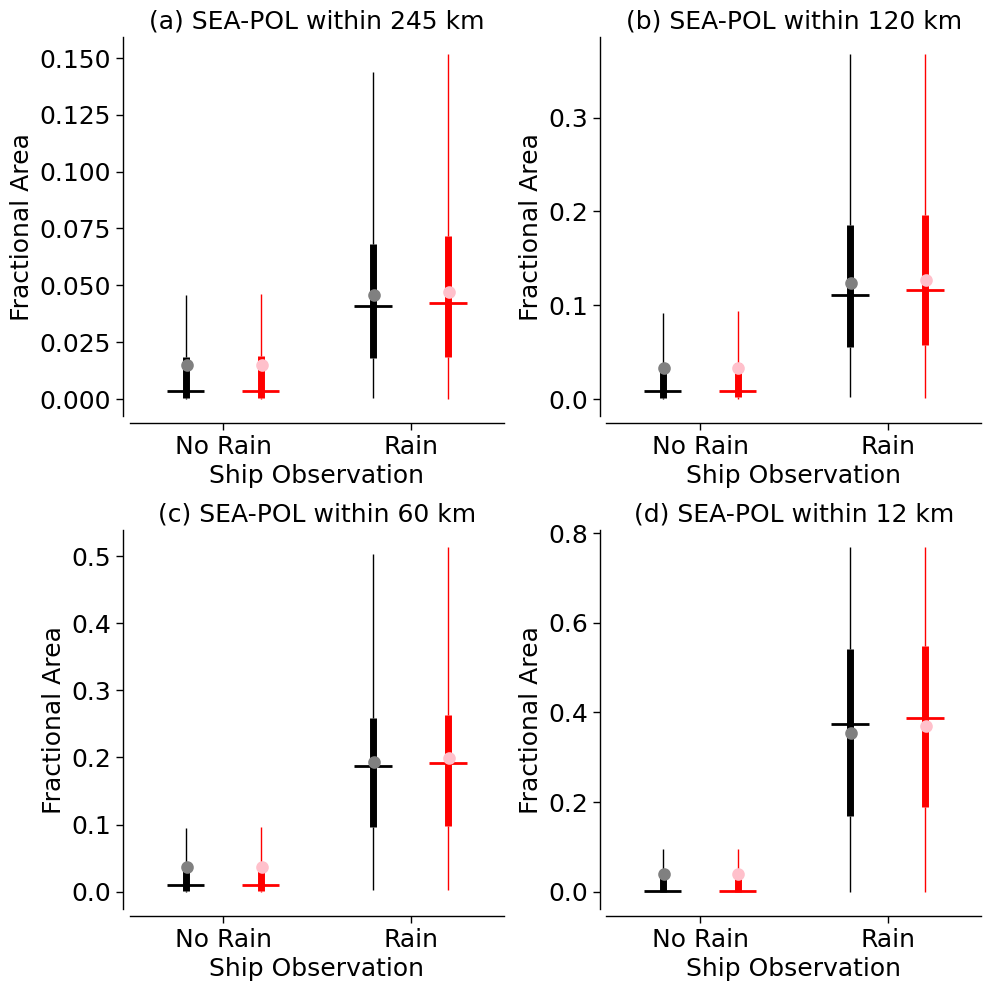

In [54]:
fig, axs = plt.subplots(2,2,figsize=(10,10))

plot_items = [(axs[0,0], fa245_gauge_zero, 'black', 'gray'),
              (axs[0,1], fa120_gauge_zero, 'black', 'gray'),
              (axs[1,0], fa60_gauge_zero, 'black', 'gray'),
              (axs[1,1], fa12_gauge_zero, 'black', 'gray')]

for ax, data_list, box_color, dot_color in plot_items:
    q1, q2, q3, mean_val = _q_stats(data_list)
    if np.isnan(q1):
        continue
    xpos_frac = 0.15 #move a bit closer to the right edge
    dx_frac = 0.05 #horizontal half-width
    
    trans = transforms.blended_transform_factory(ax.transAxes, ax.transData)
    
    # central IQR bar
    iqr_line = Line2D([xpos_frac, xpos_frac], [q1, q3],
                      transform=trans, color=box_color,
                      linewidth=5, solid_capstyle='butt', zorder=4)
    ax.add_line(iqr_line)
    # median horizontal bar
    med_line = Line2D([xpos_frac - dx_frac, xpos_frac + dx_frac], [q2, q2],
                      transform=trans, color=box_color,
                      linewidth=2, solid_capstyle='butt', zorder=5)
    ax.add_line(med_line)
    # mean marker circle
    ax.scatter([xpos_frac + dx_frac * .045], [mean_val], transform=trans,
               marker='o', edgecolor=dot_color, facecolor=dot_color, s=50,
               linewidths=2, zorder=6)
    # whiskers at 1.5 * IQR
    iqr = q3 - q1
    data_vals = np.array([v for v in data_list if not np.isnan(v)])
    if data_vals.size == 0:
        continue
    whisker_low = max(q1 - 1.5 * iqr, data_vals.min())
    whisker_high = min(q3 + 1.5 * iqr, data_vals.max())
    # whisker lines
    whisk_low_line = Line2D([xpos_frac, xpos_frac], [q1, whisker_low],
                            transform=trans, color=box_color,
                            linewidth=1, solid_capstyle='butt', zorder=3)
    whisk_high_line = Line2D([xpos_frac, xpos_frac], [q3, whisker_high],
                             transform=trans, color=box_color,
                             linewidth=1, solid_capstyle='butt', zorder=3)
    ax.add_line(whisk_low_line)
    ax.add_line(whisk_high_line)
    
plot_items = [(axs[0,0], fa245_gauge_nonzero, 'black', 'gray'),
              (axs[0,1], fa120_gauge_nonzero, 'black', 'gray'),
              (axs[1,0], fa60_gauge_nonzero, 'black', 'gray'),
              (axs[1,1], fa12_gauge_nonzero, 'black', 'gray')]
    
for ax, data_list, box_color, dot_color in plot_items:
    q1, q2, q3, mean_val = _q_stats(data_list)
    if np.isnan(q1):
        continue
    xpos_frac = 0.65 #move a bit closer to the right edge
    dx_frac = 0.05 #horizontal half-width
    
    trans = transforms.blended_transform_factory(ax.transAxes, ax.transData)
    
    # central IQR bar
    iqr_line = Line2D([xpos_frac, xpos_frac], [q1, q3],
                      transform=trans, color=box_color,
                      linewidth=5, solid_capstyle='butt', zorder=4)
    ax.add_line(iqr_line)
    # median horizontal bar
    med_line = Line2D([xpos_frac - dx_frac, xpos_frac + dx_frac], [q2, q2],
                      transform=trans, color=box_color,
                      linewidth=2, solid_capstyle='butt', zorder=5)
    ax.add_line(med_line)
    # mean marker circle
    ax.scatter([xpos_frac + dx_frac * .045], [mean_val], transform=trans,
               marker='o', edgecolor=dot_color, facecolor=dot_color, s=50,
               linewidths=2, zorder=6)
    # whiskers at 1.5 * IQR
    iqr = q3 - q1
    data_vals = np.array([v for v in data_list if not np.isnan(v)])
    if data_vals.size == 0:
        continue
    whisker_low = max(q1 - 1.5 * iqr, data_vals.min())
    whisker_high = min(q3 + 1.5 * iqr, data_vals.max())
    # whisker lines
    whisk_low_line = Line2D([xpos_frac, xpos_frac], [q1, whisker_low],
                            transform=trans, color=box_color,
                            linewidth=1, solid_capstyle='butt', zorder=3)
    whisk_high_line = Line2D([xpos_frac, xpos_frac], [q3, whisker_high],
                             transform=trans, color=box_color,
                             linewidth=1, solid_capstyle='butt', zorder=3)
    ax.add_line(whisk_low_line)
    ax.add_line(whisk_high_line)    
    
plot_items = [(axs[0,0], fa245_disdro_zero, 'red', 'pink'),
              (axs[0,1], fa120_disdro_zero, 'red', 'pink'),
              (axs[1,0], fa60_disdro_zero, 'red', 'pink'),
              (axs[1,1], fa12_disdro_zero, 'red', 'pink')]

for ax, data_list, box_color, dot_color in plot_items:
    q1, q2, q3, mean_val = _q_stats(data_list)
    if np.isnan(q1):
        continue
    xpos_frac = 0.35 #move a bit closer to the right edge
    dx_frac = 0.05 #horizontal half-width
    
    trans = transforms.blended_transform_factory(ax.transAxes, ax.transData)
    
    # central IQR bar
    iqr_line = Line2D([xpos_frac, xpos_frac], [q1, q3],
                      transform=trans, color=box_color,
                      linewidth=5, solid_capstyle='butt', zorder=4)
    ax.add_line(iqr_line)
    # median horizontal bar
    med_line = Line2D([xpos_frac - dx_frac, xpos_frac + dx_frac], [q2, q2],
                      transform=trans, color=box_color,
                      linewidth=2, solid_capstyle='butt', zorder=5)
    ax.add_line(med_line)
    # mean marker circle
    ax.scatter([xpos_frac + dx_frac * .045], [mean_val], transform=trans,
               marker='o', edgecolor=dot_color, facecolor=dot_color, s=50,
               linewidths=2, zorder=6)
    # whiskers at 1.5 * IQR
    iqr = q3 - q1
    data_vals = np.array([v for v in data_list if not np.isnan(v)])
    if data_vals.size == 0:
        continue
    whisker_low = max(q1 - 1.5 * iqr, data_vals.min())
    whisker_high = min(q3 + 1.5 * iqr, data_vals.max())
    # whisker lines
    whisk_low_line = Line2D([xpos_frac, xpos_frac], [q1, whisker_low],
                            transform=trans, color=box_color,
                            linewidth=1, solid_capstyle='butt', zorder=3)
    whisk_high_line = Line2D([xpos_frac, xpos_frac], [q3, whisker_high],
                             transform=trans, color=box_color,
                             linewidth=1, solid_capstyle='butt', zorder=3)
    ax.add_line(whisk_low_line)
    ax.add_line(whisk_high_line)
    
plot_items = [(axs[0,0], fa245_disdro_nonzero, 'red', 'pink'),
              (axs[0,1], fa120_disdro_nonzero, 'red', 'pink'),
              (axs[1,0], fa60_disdro_nonzero, 'red', 'pink'),
              (axs[1,1], fa12_disdro_nonzero, 'red', 'pink')]
    
for ax, data_list, box_color, dot_color in plot_items:
    q1, q2, q3, mean_val = _q_stats(data_list)
    if np.isnan(q1):
        continue
    xpos_frac = 0.85 #move a bit closer to the right edge
    dx_frac = 0.05 #horizontal half-width
    
    trans = transforms.blended_transform_factory(ax.transAxes, ax.transData)
    
    # central IQR bar
    iqr_line = Line2D([xpos_frac, xpos_frac], [q1, q3],
                      transform=trans, color=box_color,
                      linewidth=5, solid_capstyle='butt', zorder=4)
    ax.add_line(iqr_line)
    # median horizontal bar
    med_line = Line2D([xpos_frac - dx_frac, xpos_frac + dx_frac], [q2, q2],
                      transform=trans, color=box_color,
                      linewidth=2, solid_capstyle='butt', zorder=5)
    ax.add_line(med_line)
    # mean marker circle
    ax.scatter([xpos_frac + dx_frac * .045], [mean_val], transform=trans,
               marker='o', edgecolor=dot_color, facecolor=dot_color, s=50,
               linewidths=2, zorder=6)
    # whiskers at 1.5 * IQR
    iqr = q3 - q1
    data_vals = np.array([v for v in data_list if not np.isnan(v)])
    if data_vals.size == 0:
        continue
    whisker_low = max(q1 - 1.5 * iqr, data_vals.min())
    whisker_high = min(q3 + 1.5 * iqr, data_vals.max())
    # whisker lines
    whisk_low_line = Line2D([xpos_frac, xpos_frac], [q1, whisker_low],
                            transform=trans, color=box_color,
                            linewidth=1, solid_capstyle='butt', zorder=3)
    whisk_high_line = Line2D([xpos_frac, xpos_frac], [q3, whisker_high],
                             transform=trans, color=box_color,
                             linewidth=1, solid_capstyle='butt', zorder=3)
    ax.add_line(whisk_low_line)
    ax.add_line(whisk_high_line)
    
# set plot attributes
axs[0,0].set_title('(a) SEA-POL within 245 km',fontsize=18)
axs[0,0].set_ylabel('Fractional Area',fontsize=18)
axs[0,0].set_xlabel('Ship Observation',fontsize=18)
axs[0,0].set_xticks([0.25,0.75])
axs[0,0].set_xlim(0,1)
axs[0,0].set_xticklabels(['No Rain','Rain'],fontsize=18)
axs[0,0].tick_params(labelsize=18)

axs[0,1].set_title('(b) SEA-POL within 120 km',fontsize=18)
axs[0,1].set_ylabel('Fractional Area',fontsize=18)
axs[0,1].set_xlabel('Ship Observation',fontsize=18)
axs[0,1].set_xticks([0.25,0.75])
axs[0,1].set_xlim(0,1)
axs[0,1].set_xticklabels(['No Rain','Rain'],fontsize=18)
axs[0,1].tick_params(labelsize=18)

axs[1,0].set_title('(c) SEA-POL within 60 km',fontsize=18)
axs[1,0].set_ylabel('Fractional Area',fontsize=18)
axs[1,0].set_xlabel('Ship Observation',fontsize=18)
axs[1,0].set_xticks([0.25,0.75])
axs[1,0].set_xlim(0,1)
axs[1,0].set_xticklabels(['No Rain','Rain'],fontsize=18)
axs[1,0].tick_params(labelsize=18)

axs[1,1].set_title('(d) SEA-POL within 12 km',fontsize=18)
axs[1,1].set_ylabel('Fractional Area',fontsize=18)
axs[1,1].set_xlabel('Ship Observation',fontsize=18)
axs[1,1].set_xticks([0.25,0.75])
axs[1,1].set_xlim(0,1)
axs[1,1].set_xticklabels(['No Rain','Rain'],fontsize=18)
axs[1,1].tick_params(labelsize=18)

sns.set_context('paper') 
sns.despine(offset=5)
plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.savefig('../../figures/Fig_precip_fa_ship_boxplots.png')   

In [34]:
# How often is the fractional area greater than average when the ship observes no rain?
fa245_disdro_zero_gtmean = fa245_disdro_zero.where(fa245_disdro_zero > np.nanmean(seapol.rain245_frac))
fa245_disdro_zero_gtmean_count = np.count_nonzero(~np.isnan(fa245_disdro_zero_gtmean))
fa245_disdro_zero_count = np.count_nonzero(~np.isnan(fa245_disdro_zero))
print(f"Fraction of times FA245 is greater than mean when ship disdro observes no rain: {fa245_disdro_zero_gtmean_count/fa245_disdro_zero_count:.2f}")
 
fa120_disdro_zero_gtmean = fa120_disdro_zero.where(fa120_disdro_zero > np.nanmean(seapol.rain120_frac))
fa120_disdro_zero_gtmean_count = np.count_nonzero(~np.isnan(fa120_disdro_zero_gtmean))
fa120_disdro_zero_count = np.count_nonzero(~np.isnan(fa120_disdro_zero))
print(f"Fraction of times FA120 is greater than mean when ship disdro observes no rain: {fa120_disdro_zero_gtmean_count/fa120_disdro_zero_count:.2f}")

fa60_disdro_zero_gtmean = fa60_disdro_zero.where(fa60_disdro_zero > np.nanmean(seapol.rain60_frac))
fa60_disdro_zero_gtmean_count = np.count_nonzero(~np.isnan(fa60_disdro_zero_gtmean))
fa60_disdro_zero_count = np.count_nonzero(~np.isnan(fa60_disdro_zero))
print(f"Fraction of times FA60 is greater than mean when ship disdro observes no rain: {fa60_disdro_zero_gtmean_count/fa60_disdro_zero_count:.2f}")

fa12_disdro_zero_gtmean = fa12_disdro_zero.where(fa12_disdro_zero > np.nanmean(seapol.rain12_frac))
fa12_disdro_zero_gtmean_count = np.count_nonzero(~np.isnan(fa12_disdro_zero_gtmean))
fa12_disdro_zero_count = np.count_nonzero(~np.isnan(fa12_disdro_zero))
print(f"Fraction of times FA12 is greater than mean when ship disdro observes no rain: {fa12_disdro_zero_gtmean_count/fa12_disdro_zero_count:.2f}")

Fraction of times FA245 is greater than mean when ship disdro observes no rain: 0.25
Fraction of times FA120 is greater than mean when ship disdro observes no rain: 0.23
Fraction of times FA60 is greater than mean when ship disdro observes no rain: 0.19
Fraction of times FA12 is greater than mean when ship disdro observes no rain: 0.15


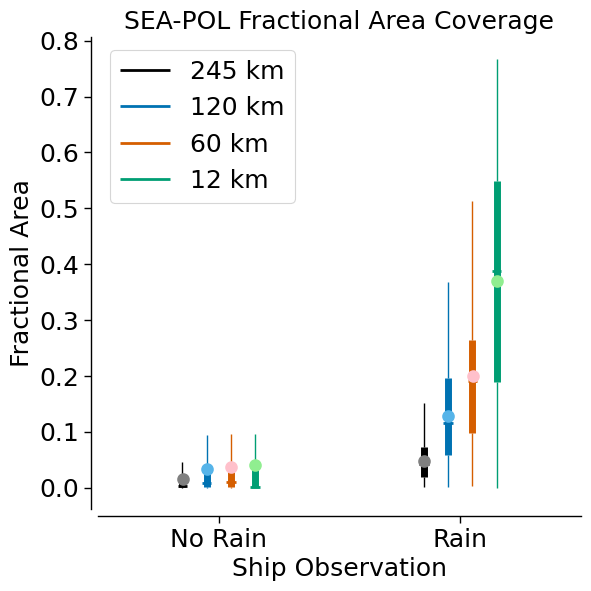

In [53]:
fig, axs = plt.subplots(figsize=(6,6))

plot_items = [(axs, fa245_disdro_zero, 'black', 'gray','245 km'),
              (axs, fa120_disdro_zero, cb_blue, cb_skyblue,'120 km'),
              (axs, fa60_disdro_zero, cb_red, 'pink','60 km'),
              (axs, fa12_disdro_zero, cb_green, 'lightgreen','12 km')]

shift = 0
for ax, data_list, box_color, dot_color, legend_label in plot_items:
    q1, q2, q3, mean_val = _q_stats(data_list)
    if np.isnan(q1):
        continue
    xpos_frac = 0.175 + shift #move a bit closer to the right edge
    dx_frac = 0.01 #horizontal half-width
    
    trans = transforms.blended_transform_factory(ax.transAxes, ax.transData)
    
    # central IQR bar
    iqr_line = Line2D([xpos_frac, xpos_frac], [q1, q3],
                      transform=trans, color=box_color,
                      linewidth=5, solid_capstyle='butt', zorder=4)
    ax.add_line(iqr_line)
    # median horizontal bar
    med_line = Line2D([xpos_frac - dx_frac, xpos_frac + dx_frac], [q2, q2],
                      transform=trans, color=box_color,
                      linewidth=2, solid_capstyle='butt', label = legend_label, zorder=5)
    ax.add_line(med_line)
    # mean marker circle
    ax.scatter([xpos_frac + dx_frac * .045], [mean_val], transform=trans,
               marker='o', edgecolor=dot_color, facecolor=dot_color, s=50,
               linewidths=2, zorder=6)
    # whiskers at 1.5 * IQR
    iqr = q3 - q1
    data_vals = np.array([v for v in data_list if not np.isnan(v)])
    if data_vals.size == 0:
        continue
    whisker_low = max(q1 - 1.5 * iqr, data_vals.min())
    whisker_high = min(q3 + 1.5 * iqr, data_vals.max())
    # whisker lines
    whisk_low_line = Line2D([xpos_frac, xpos_frac], [q1, whisker_low],
                            transform=trans, color=box_color,
                            linewidth=1, solid_capstyle='butt', zorder=3)
    whisk_high_line = Line2D([xpos_frac, xpos_frac], [q3, whisker_high],
                             transform=trans, color=box_color,
                             linewidth=1, solid_capstyle='butt', zorder=3)
    ax.add_line(whisk_low_line)
    ax.add_line(whisk_high_line)
    
    shift += 0.05
    
plot_items = [(axs, fa245_disdro_nonzero, 'black', 'gray'),
              (axs, fa120_disdro_nonzero, cb_blue, cb_skyblue),
              (axs, fa60_disdro_nonzero, cb_red, 'pink'),
              (axs, fa12_disdro_nonzero, cb_green, 'lightgreen')]

shift = 0
for ax, data_list, box_color, dot_color in plot_items:
    q1, q2, q3, mean_val = _q_stats(data_list)
    if np.isnan(q1):
        continue
    xpos_frac = 0.675 + shift #move a bit closer to the right edge
    dx_frac = 0.01 #horizontal half-width
    
    trans = transforms.blended_transform_factory(ax.transAxes, ax.transData)
    
    # central IQR bar
    iqr_line = Line2D([xpos_frac, xpos_frac], [q1, q3],
                      transform=trans, color=box_color,
                      linewidth=5, solid_capstyle='butt', zorder=4)
    ax.add_line(iqr_line)
    # median horizontal bar
    med_line = Line2D([xpos_frac - dx_frac, xpos_frac + dx_frac], [q2, q2],
                      transform=trans, color=box_color,
                      linewidth=2, solid_capstyle='butt', zorder=5)
    ax.add_line(med_line)
    # mean marker circle
    ax.scatter([xpos_frac + dx_frac * .045], [mean_val], transform=trans,
               marker='o', edgecolor=dot_color, facecolor=dot_color, s=50,
               linewidths=2, zorder=6)
    # whiskers at 1.5 * IQR
    iqr = q3 - q1
    data_vals = np.array([v for v in data_list if not np.isnan(v)])
    if data_vals.size == 0:
        continue
    whisker_low = max(q1 - 1.5 * iqr, data_vals.min())
    whisker_high = min(q3 + 1.5 * iqr, data_vals.max())
    # whisker lines
    whisk_low_line = Line2D([xpos_frac, xpos_frac], [q1, whisker_low],
                            transform=trans, color=box_color,
                            linewidth=1, solid_capstyle='butt', zorder=3)
    whisk_high_line = Line2D([xpos_frac, xpos_frac], [q3, whisker_high],
                             transform=trans, color=box_color,
                             linewidth=1, solid_capstyle='butt', zorder=3)
    ax.add_line(whisk_low_line)
    ax.add_line(whisk_high_line)
    
    shift += 0.05

    
# set plot attributes
axs.set_title('SEA-POL Fractional Area Coverage',fontsize=18)
axs.set_ylabel('Fractional Area',fontsize=18)
axs.set_xlabel('Ship Observation',fontsize=18)
axs.set_xticks([0.25,0.75])
axs.set_xlim(0,1)
axs.set_xticklabels(['No Rain','Rain'],fontsize=18)
axs.tick_params(labelsize=18)
plt.legend(fontsize=18, loc='upper left')


sns.set_context('paper') 
sns.despine(offset=5)
plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.savefig('../../figures/Fig_precip_fa_ship_boxplot.png')   

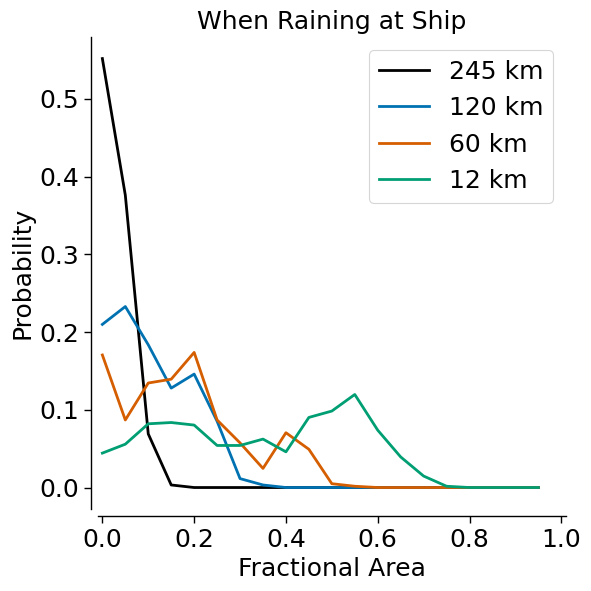

In [89]:
# Fractional area distribution when it is raining at the ship
# 
fig, axs = plt.subplots(figsize=(6,6))

fabins = np.arange(0,1.05,0.05)

phist_fa245_dnz, bin_edges_dnz = np.histogram(fa245_disdro_nonzero, bins=fabins, density=True)
phist_fa120_dnz, bin_edges_dnz = np.histogram(fa120_disdro_nonzero, bins=fabins, density=True)
phist_fa60_dnz, bin_edges_dnz = np.histogram(fa60_disdro_nonzero, bins=fabins, density=True)
phist_fa12_dnz, bin_edges_dnz = np.histogram(fa12_disdro_nonzero, bins=fabins, density=True)

axs.plot(bin_edges_dnz[:-1], phist_fa245_dnz*np.diff(bin_edges_dnz), color='black',label = '245 km', linewidth=2)
axs.plot(bin_edges_dnz[:-1], phist_fa120_dnz*np.diff(bin_edges_dnz), color=cb_blue,label = '120 km', linewidth=2)
axs.plot(bin_edges_dnz[:-1], phist_fa60_dnz*np.diff(bin_edges_dnz), color=cb_red,label = '60 km', linewidth=2)
axs.plot(bin_edges_dnz[:-1], phist_fa12_dnz*np.diff(bin_edges_dnz), color=cb_green,label = '12 km', linewidth=2)

# set plot attributes
axs.set_title('When Raining at Ship',fontsize=18)
axs.set_ylabel('Probability',fontsize=18)
axs.set_xlabel('Fractional Area',fontsize=18)
axs.set_xlim(-0.01,1.01)
axs.tick_params(labelsize=18)
plt.legend(fontsize=18, loc='upper right')

sns.set_context('paper') 
sns.despine(offset=5)
plt.tight_layout()  # Adjust subplots to fit into figure area.

plt.savefig('../../figures/Fig_precip_fa_ship_rain.png')

In [82]:
#When the fractional area is above its 95th percentile, how often is it raining at the ship?
which_prctile = 95
fa245_i95 = np.where(seapol.rain245_frac >= np.nanpercentile(seapol.rain245_frac, [which_prctile]))
precip_freq_disdro_i95 = precip_freq_disdro[fa245_i95]
print(f"Fraction of time 10-min precip freq is greater than {pfreq_threshold} when FA245 is above its 95th percentile: {np.count_nonzero(precip_freq_disdro_i95 > pfreq_threshold)/precip_freq_disdro_i95.size:.2f}")

fa120_i95 = np.where(seapol.rain120_frac >= np.nanpercentile(seapol.rain120_frac, [which_prctile]))
precip_freq_disdro_i95 = precip_freq_disdro[fa120_i95]
print(f"Fraction of time 10-min precip freq is greater than {pfreq_threshold} when FA120 is above its 95th percentile: {np.count_nonzero(precip_freq_disdro_i95 > pfreq_threshold)/precip_freq_disdro_i95.size:.2f}")

fa60_i95 = np.where(seapol.rain60_frac >= np.nanpercentile(seapol.rain60_frac, [which_prctile]))
precip_freq_disdro_i95 = precip_freq_disdro[fa60_i95]
print(f"Fraction of time 10-min precip freq is greater than {pfreq_threshold} when FA60 is above its 95th percentile: {np.count_nonzero(precip_freq_disdro_i95 > pfreq_threshold)/precip_freq_disdro_i95.size:.2f}")

fa12_i95 = np.where(seapol.rain12_frac >= np.nanpercentile(seapol.rain12_frac, [which_prctile]))
precip_freq_disdro_i95 = precip_freq_disdro[fa12_i95]
print(f"Fraction of time 10-min precip freq is greater than {pfreq_threshold} when FA12 is above its 95th percentile: {np.count_nonzero(precip_freq_disdro_i95 > pfreq_threshold)/precip_freq_disdro_i95.size:.2f}")

Fraction of time 10-min precip freq is greater than 0 when FA245 is above its 95th percentile: 0.41
Fraction of time 10-min precip freq is greater than 0 when FA120 is above its 95th percentile: 0.56
Fraction of time 10-min precip freq is greater than 0 when FA60 is above its 95th percentile: 0.65
Fraction of time 10-min precip freq is greater than 0 when FA12 is above its 95th percentile: 0.85


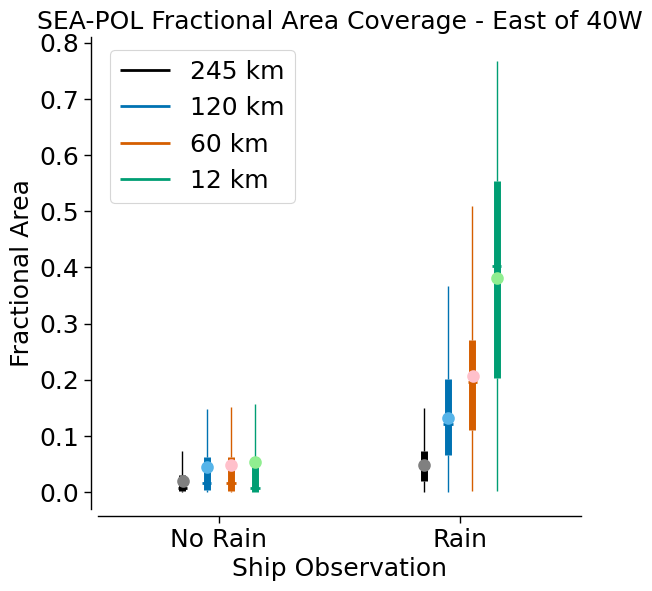

In [122]:
fig, axs = plt.subplots(figsize=(6,6))

plot_items = [(axs, fa245_disdro_zeroE, 'black', 'gray','245 km'),
              (axs, fa120_disdro_zeroE, cb_blue, cb_skyblue,'120 km'),
              (axs, fa60_disdro_zeroE, cb_red, 'pink','60 km'),
              (axs, fa12_disdro_zeroE, cb_green, 'lightgreen','12 km')]

shift = 0
for ax, data_list, box_color, dot_color, legend_label in plot_items:
    q1, q2, q3, mean_val = _q_stats(data_list)
    if np.isnan(q1):
        continue
    xpos_frac = 0.175 + shift #move a bit closer to the right edge
    dx_frac = 0.01 #horizontal half-width
    
    trans = transforms.blended_transform_factory(ax.transAxes, ax.transData)
    
    # central IQR bar
    iqr_line = Line2D([xpos_frac, xpos_frac], [q1, q3],
                      transform=trans, color=box_color,
                      linewidth=5, solid_capstyle='butt', zorder=4)
    ax.add_line(iqr_line)
    # median horizontal bar
    med_line = Line2D([xpos_frac - dx_frac, xpos_frac + dx_frac], [q2, q2],
                      transform=trans, color=box_color,
                      linewidth=2, solid_capstyle='butt', label = legend_label, zorder=5)
    ax.add_line(med_line)
    # mean marker circle
    ax.scatter([xpos_frac + dx_frac * .045], [mean_val], transform=trans,
               marker='o', edgecolor=dot_color, facecolor=dot_color, s=50,
               linewidths=2, zorder=6)
    # whiskers at 1.5 * IQR
    iqr = q3 - q1
    data_vals = np.array([v for v in data_list if not np.isnan(v)])
    if data_vals.size == 0:
        continue
    whisker_low = max(q1 - 1.5 * iqr, data_vals.min())
    whisker_high = min(q3 + 1.5 * iqr, data_vals.max())
    # whisker lines
    whisk_low_line = Line2D([xpos_frac, xpos_frac], [q1, whisker_low],
                            transform=trans, color=box_color,
                            linewidth=1, solid_capstyle='butt', zorder=3)
    whisk_high_line = Line2D([xpos_frac, xpos_frac], [q3, whisker_high],
                             transform=trans, color=box_color,
                             linewidth=1, solid_capstyle='butt', zorder=3)
    ax.add_line(whisk_low_line)
    ax.add_line(whisk_high_line)
    
    shift += 0.05
    
plot_items = [(axs, fa245_disdro_nonzeroE, 'black', 'gray'),
              (axs, fa120_disdro_nonzeroE, cb_blue, cb_skyblue),
              (axs, fa60_disdro_nonzeroE, cb_red, 'pink'),
              (axs, fa12_disdro_nonzeroE, cb_green, 'lightgreen')]

shift = 0
for ax, data_list, box_color, dot_color in plot_items:
    q1, q2, q3, mean_val = _q_stats(data_list)
    if np.isnan(q1):
        continue
    xpos_frac = 0.675 + shift #move a bit closer to the right edge
    dx_frac = 0.01 #horizontal half-width
    
    trans = transforms.blended_transform_factory(ax.transAxes, ax.transData)
    
    # central IQR bar
    iqr_line = Line2D([xpos_frac, xpos_frac], [q1, q3],
                      transform=trans, color=box_color,
                      linewidth=5, solid_capstyle='butt', zorder=4)
    ax.add_line(iqr_line)
    # median horizontal bar
    med_line = Line2D([xpos_frac - dx_frac, xpos_frac + dx_frac], [q2, q2],
                      transform=trans, color=box_color,
                      linewidth=2, solid_capstyle='butt', zorder=5)
    ax.add_line(med_line)
    # mean marker circle
    ax.scatter([xpos_frac + dx_frac * .045], [mean_val], transform=trans,
               marker='o', edgecolor=dot_color, facecolor=dot_color, s=50,
               linewidths=2, zorder=6)
    # whiskers at 1.5 * IQR
    iqr = q3 - q1
    data_vals = np.array([v for v in data_list if not np.isnan(v)])
    if data_vals.size == 0:
        continue
    whisker_low = max(q1 - 1.5 * iqr, data_vals.min())
    whisker_high = min(q3 + 1.5 * iqr, data_vals.max())
    # whisker lines
    whisk_low_line = Line2D([xpos_frac, xpos_frac], [q1, whisker_low],
                            transform=trans, color=box_color,
                            linewidth=1, solid_capstyle='butt', zorder=3)
    whisk_high_line = Line2D([xpos_frac, xpos_frac], [q3, whisker_high],
                             transform=trans, color=box_color,
                             linewidth=1, solid_capstyle='butt', zorder=3)
    ax.add_line(whisk_low_line)
    ax.add_line(whisk_high_line)
    
    shift += 0.05

    
# set plot attributes
axs.set_title('SEA-POL Fractional Area Coverage - East of 40W',fontsize=18)
axs.set_ylabel('Fractional Area',fontsize=18)
axs.set_xlabel('Ship Observation',fontsize=18)
axs.set_xticks([0.25,0.75])
axs.set_xlim(0,1)
axs.set_ylim(-0.03, 0.81)
axs.set_xticklabels(['No Rain','Rain'],fontsize=18)
axs.tick_params(labelsize=18)
plt.legend(fontsize=18, loc='upper left')


sns.set_context('paper') 
sns.despine(offset=5)
plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.savefig('../../figures/Fig_precip_fa_ship_boxplotE.png')   

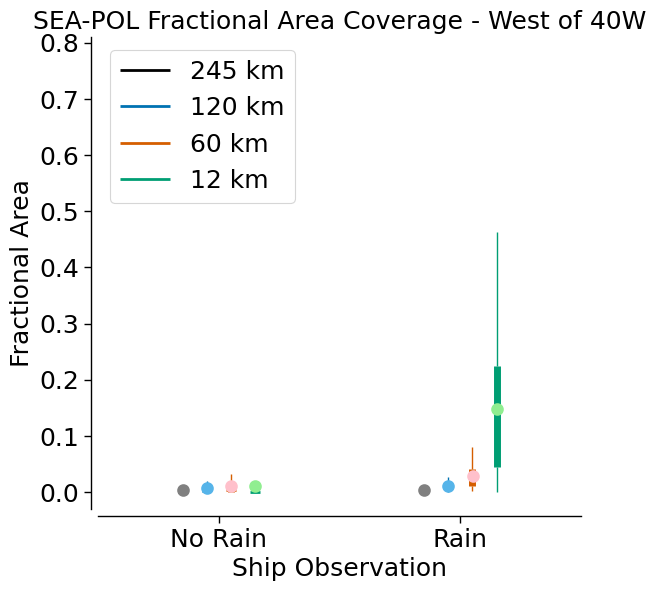

In [123]:
fig, axs = plt.subplots(figsize=(6,6))

plot_items = [(axs, fa245_disdro_zeroW, 'black', 'gray','245 km'),
              (axs, fa120_disdro_zeroW, cb_blue, cb_skyblue,'120 km'),
              (axs, fa60_disdro_zeroW, cb_red, 'pink','60 km'),
              (axs, fa12_disdro_zeroW, cb_green, 'lightgreen','12 km')]

shift = 0
for ax, data_list, box_color, dot_color, legend_label in plot_items:
    q1, q2, q3, mean_val = _q_stats(data_list)
    if np.isnan(q1):
        continue
    xpos_frac = 0.175 + shift #move a bit closer to the right edge
    dx_frac = 0.01 #horizontal half-width
    
    trans = transforms.blended_transform_factory(ax.transAxes, ax.transData)
    
    # central IQR bar
    iqr_line = Line2D([xpos_frac, xpos_frac], [q1, q3],
                      transform=trans, color=box_color,
                      linewidth=5, solid_capstyle='butt', zorder=4)
    ax.add_line(iqr_line)
    # median horizontal bar
    med_line = Line2D([xpos_frac - dx_frac, xpos_frac + dx_frac], [q2, q2],
                      transform=trans, color=box_color,
                      linewidth=2, solid_capstyle='butt', label = legend_label, zorder=5)
    ax.add_line(med_line)
    # mean marker circle
    ax.scatter([xpos_frac + dx_frac * .045], [mean_val], transform=trans,
               marker='o', edgecolor=dot_color, facecolor=dot_color, s=50,
               linewidths=2, zorder=6)
    # whiskers at 1.5 * IQR
    iqr = q3 - q1
    data_vals = np.array([v for v in data_list if not np.isnan(v)])
    if data_vals.size == 0:
        continue
    whisker_low = max(q1 - 1.5 * iqr, data_vals.min())
    whisker_high = min(q3 + 1.5 * iqr, data_vals.max())
    # whisker lines
    whisk_low_line = Line2D([xpos_frac, xpos_frac], [q1, whisker_low],
                            transform=trans, color=box_color,
                            linewidth=1, solid_capstyle='butt', zorder=3)
    whisk_high_line = Line2D([xpos_frac, xpos_frac], [q3, whisker_high],
                             transform=trans, color=box_color,
                             linewidth=1, solid_capstyle='butt', zorder=3)
    ax.add_line(whisk_low_line)
    ax.add_line(whisk_high_line)
    
    shift += 0.05
    
plot_items = [(axs, fa245_disdro_nonzeroW, 'black', 'gray'),
              (axs, fa120_disdro_nonzeroW, cb_blue, cb_skyblue),
              (axs, fa60_disdro_nonzeroW, cb_red, 'pink'),
              (axs, fa12_disdro_nonzeroW, cb_green, 'lightgreen')]

shift = 0
for ax, data_list, box_color, dot_color in plot_items:
    q1, q2, q3, mean_val = _q_stats(data_list)
    if np.isnan(q1):
        continue
    xpos_frac = 0.675 + shift #move a bit closer to the right edge
    dx_frac = 0.01 #horizontal half-width
    
    trans = transforms.blended_transform_factory(ax.transAxes, ax.transData)
    
    # central IQR bar
    iqr_line = Line2D([xpos_frac, xpos_frac], [q1, q3],
                      transform=trans, color=box_color,
                      linewidth=5, solid_capstyle='butt', zorder=4)
    ax.add_line(iqr_line)
    # median horizontal bar
    med_line = Line2D([xpos_frac - dx_frac, xpos_frac + dx_frac], [q2, q2],
                      transform=trans, color=box_color,
                      linewidth=2, solid_capstyle='butt', zorder=5)
    ax.add_line(med_line)
    # mean marker circle
    ax.scatter([xpos_frac + dx_frac * .045], [mean_val], transform=trans,
               marker='o', edgecolor=dot_color, facecolor=dot_color, s=50,
               linewidths=2, zorder=6)
    # whiskers at 1.5 * IQR
    iqr = q3 - q1
    data_vals = np.array([v for v in data_list if not np.isnan(v)])
    if data_vals.size == 0:
        continue
    whisker_low = max(q1 - 1.5 * iqr, data_vals.min())
    whisker_high = min(q3 + 1.5 * iqr, data_vals.max())
    # whisker lines
    whisk_low_line = Line2D([xpos_frac, xpos_frac], [q1, whisker_low],
                            transform=trans, color=box_color,
                            linewidth=1, solid_capstyle='butt', zorder=3)
    whisk_high_line = Line2D([xpos_frac, xpos_frac], [q3, whisker_high],
                             transform=trans, color=box_color,
                             linewidth=1, solid_capstyle='butt', zorder=3)
    ax.add_line(whisk_low_line)
    ax.add_line(whisk_high_line)
    
    shift += 0.05

    
# set plot attributes
axs.set_title('SEA-POL Fractional Area Coverage - West of 40W',fontsize=18)
axs.set_ylabel('Fractional Area',fontsize=18)
axs.set_xlabel('Ship Observation',fontsize=18)
axs.set_xticks([0.25,0.75])
axs.set_xlim(0,1)
axs.set_ylim(-0.03, 0.81)
axs.set_xticklabels(['No Rain','Rain'],fontsize=18)
axs.tick_params(labelsize=18)
plt.legend(fontsize=18, loc='upper left')


sns.set_context('paper') 
sns.despine(offset=5)
plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.savefig('../../figures/Fig_precip_fa_ship_boxplotW.png')   

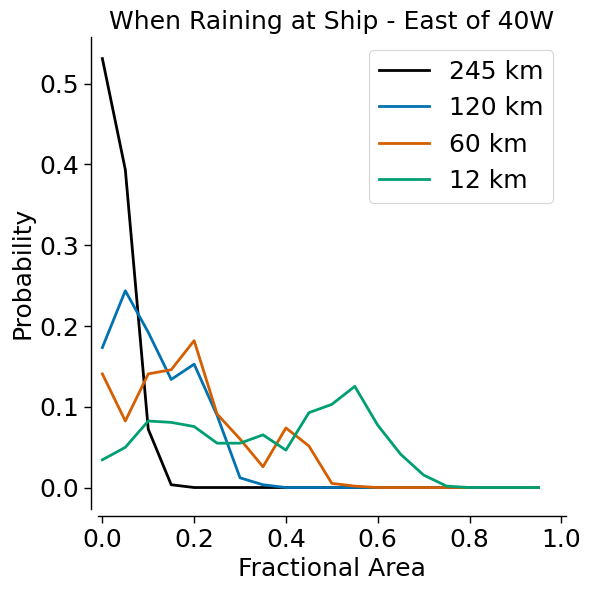

In [129]:
# Fractional area distribution when it is raining at the ship - EAST
# 
fig, axs = plt.subplots(figsize=(6,6))

fabins = np.arange(0,1.05,0.05)

phist_fa245_dnz, bin_edges_dnz = np.histogram(fa245_disdro_nonzeroE, bins=fabins, density=True)
phist_fa120_dnz, bin_edges_dnz = np.histogram(fa120_disdro_nonzeroE, bins=fabins, density=True)
phist_fa60_dnz, bin_edges_dnz = np.histogram(fa60_disdro_nonzeroE, bins=fabins, density=True)
phist_fa12_dnz, bin_edges_dnz = np.histogram(fa12_disdro_nonzeroE, bins=fabins, density=True)

axs.plot(bin_edges_dnz[:-1], phist_fa245_dnz*np.diff(bin_edges_dnz), color='black',label = '245 km', linewidth=2)
axs.plot(bin_edges_dnz[:-1], phist_fa120_dnz*np.diff(bin_edges_dnz), color=cb_blue,label = '120 km', linewidth=2)
axs.plot(bin_edges_dnz[:-1], phist_fa60_dnz*np.diff(bin_edges_dnz), color=cb_red,label = '60 km', linewidth=2)
axs.plot(bin_edges_dnz[:-1], phist_fa12_dnz*np.diff(bin_edges_dnz), color=cb_green,label = '12 km', linewidth=2)

# set plot attributes
axs.set_title('When Raining at Ship - East of 40W',fontsize=18)
axs.set_ylabel('Probability',fontsize=18)
axs.set_xlabel('Fractional Area',fontsize=18)
axs.set_xlim(-0.01,1.01)
axs.tick_params(labelsize=18)
plt.legend(fontsize=18, loc='upper right')

sns.set_context('paper') 
sns.despine(offset=5)
plt.tight_layout()  # Adjust subplots to fit into figure area.

plt.savefig('../../figures/Fig_precip_fa_ship_rainE.png')

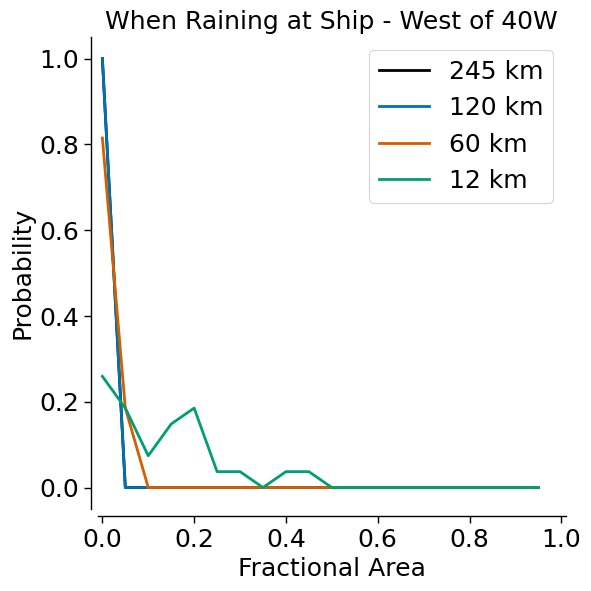

In [ ]:
# Fractional area distribution when it is raining at the ship - West
# 
fig, axs = plt.subplots(figsize=(6,6))

fabins = np.arange(0,1.05,0.05)

phist_fa245_dnz, bin_edges_dnz = np.histogram(fa245_disdro_nonzeroW, bins=fabins, density=True)
phist_fa120_dnz, bin_edges_dnz = np.histogram(fa120_disdro_nonzeroW, bins=fabins, density=True)
phist_fa60_dnz, bin_edges_dnz = np.histogram(fa60_disdro_nonzeroW, bins=fabins, density=True)
phist_fa12_dnz, bin_edges_dnz = np.histogram(fa12_disdro_nonzeroW, bins=fabins, density=True)

axs.plot(bin_edges_dnz[:-1], phist_fa245_dnz*np.diff(bin_edges_dnz), color='black',label = '245 km', linewidth=2)
axs.plot(bin_edges_dnz[:-1], phist_fa120_dnz*np.diff(bin_edges_dnz), color=cb_blue,label = '120 km', linewidth=2)
axs.plot(bin_edges_dnz[:-1], phist_fa60_dnz*np.diff(bin_edges_dnz), color=cb_red,label = '60 km', linewidth=2)
axs.plot(bin_edges_dnz[:-1], phist_fa12_dnz*np.diff(bin_edges_dnz), color=cb_green,label = '12 km', linewidth=2)

# set plot attributes
axs.set_title('When Raining at Ship - West of 40W',fontsize=18)
axs.set_ylabel('Probability',fontsize=18)
axs.set_xlabel('Fractional Area',fontsize=18)
axs.set_xlim(-0.01,1.01)
axs.tick_params(labelsize=18)
plt.legend(fontsize=18, loc='upper right')

sns.set_context('paper') 
sns.despine(offset=5)
plt.tight_layout()  # Adjust subplots to fit into figure area.

plt.savefig('../../figures/Fig_precip_fa_ship_rainW.png')